Projekt ten ma na celu stworzenie architektury sieci neuronowej oraz wytrenowanie jej wraz z doborem hiperparametrów tak, aby osiągnąć możliwie największe wartości wskazanych metryk.

Wykorzystywany dataset: https://www.kaggle.com/datasets/alessiocorrado99/animals10/data

26 191 elementów

In [2]:
# Potrzebne biblioteki

import pathlib
import PIL.Image as Image
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
import time

import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Num GPUs Available:  1


In [3]:
!pip install neptune
!pip install neptune-tensorflow-keras

  Obtaining dependency information for neptune from https://files.pythonhosted.org/packages/82/6c/543a4d807cc0b2e03ec50f74d2ddf150903281e3fd5e29d9ff7ac9d0e658/neptune-1.8.5-py3-none-any.whl.metadata
  Obtaining dependency information for boto3>=1.28.0 from https://files.pythonhosted.org/packages/45/78/e95de33d8850429f6740763eb2d5350c02fd39e916f2ddb69fe649d25125/boto3-1.29.6-py3-none-any.whl.metadata
  Obtaining dependency information for botocore<1.33.0,>=1.32.6 from https://files.pythonhosted.org/packages/e4/dd/a6c7154d4f045599ce2df9199c01a8c2650c45ae74ad63f69547a500cc1c/botocore-1.32.6-py3-none-any.whl.metadata
  Obtaining dependency information for s3transfer<0.8.0,>=0.7.0 from https://files.pythonhosted.org/packages/5a/4b/fec9ce18f8874a96c5061422625ba86c3ee1e6587ccd92ff9f5bf7bd91b2/s3transfer-0.7.0-py3-none-any.whl.metadata
  Obtaining dependency information for bravado-core>=5.16.1 from https://files.pythonhosted.org/packages/5f/26/7fdeaa8b87bbf2a7d05230d4e9f40b232aff4527fe2d582aa

In [18]:
import neptune
from getpass import getpass

api_token = ""
project= "m.golebiowska556/NNanimals"
project = neptune.init_project(project=project, api_token=api_token)
print(project)

run = neptune.init_run(
    project="m.golebiowska556/NNanimals",
    api_token=api_token,
    capture_hardware_metrics=True,
    capture_stderr=True,
    capture_stdout=True,
)

https://app.neptune.ai/m.golebiowska556/NNanimals/
https://app.neptune.ai/m.golebiowska556/NNanimals/e/NNAN-15


# 1. Przygotowanie danych

In [ ]:
# Sprawdzenie ilości obrazów w folderach

ROOT_DIR = "/kaggle/input/animals10/raw-img"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))


print(number_of_images.items())
center = []
number_arr = []
label_arr = ['horse','sheep', 'elephant', 'cat', 'squirrel', 'chicken', 'spider', 'cow', 'dog','butterfly']
for label, number in number_of_images.items():
    number_arr.append(number)
    
plt.figure(figsize=(15, 15)) 
plt.bar(label_arr, number_arr)

plt.savefig("/kaggle/working/class_plot.pdf", format="pdf", bbox_inches="tight")

oversampling, undersampling - inb learn
albo ważenie klas

# 3.1 Wybrany model - VGG16

https://www.kaggle.com/code/atishaygwari/transfer-learning-vgg16-93

porownanie naszej, a tej z transfer learningu

intuicyjne parametry, adaptive learning

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size']=14

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
img_size=224
batch_size=64
directory='/kaggle/input/animals10/raw-img'

# horizontal flip i zoom

traingen=ImageDataGenerator(rescale=1/255.,
                           zoom_range=0.2,
                           horizontal_flip=True,
                           validation_split=.15)

traindata=traingen.flow_from_directory(directory,
                                       target_size=(img_size,img_size)
                                       ,batch_size=batch_size,
                                       shuffle=True,class_mode='categorical',
                                      subset='training')


valdata=valgen.flow_from_directory(directory,
                                    shuffle=False,batch_size=batch_size,
                                    target_size=(img_size,img_size),
                                    class_mode="categorical",subset='validation')

Found 22257 images belonging to 10 classes.
Found 3922 images belonging to 10 classes.


In [11]:
# DATA OVERSAMPLING

img_size=224
batch_size=64
directory='/kaggle/input/animals10/raw-img'

traingen=ImageDataGenerator(rescale=1/255.,
                           validation_split=.15)

traindata=traingen.flow_from_directory(directory,
                                       target_size=(img_size,img_size)
                                       ,batch_size=batch_size,
                                       shuffle=True,class_mode='categorical',
                                      subset='training')


valdata=traingen.flow_from_directory(directory,
                                    shuffle=False,batch_size=batch_size,
                                    target_size=(img_size,img_size),
                                    class_mode="categorical",subset='validation')

print(traindata.batch_index)

x_train, y_train = [], []
batch_index = 0
while batch_index <= 100:
    images_array, labels_array = next(traindata)
    for i in range(len(images_array)):
        x_train.append(images_array[i])
#         label = np.argmax(labels_array[i])
        y_train.append(labels_array[i])
    batch_index = batch_index + 1

x_train = np.array(x_train)   
y_train = np.array(y_train)   
print(x_train.shape)

reshaped_x = x_train.reshape(x_train.shape[0],-1)


from imblearn.over_sampling import RandomOverSampler

#oversampling
oversample = RandomOverSampler(sampling_strategy='auto')
oversampled_x_train, oversampled_y_train  = oversample.fit_resample(reshaped_x, y_train)
oversampled_x_train = oversampled_x_train.reshape(-1,224,224,3)



Found 22257 images belonging to 10 classes.
Found 3922 images belonging to 10 classes.
0
(6464, 224, 224, 3)


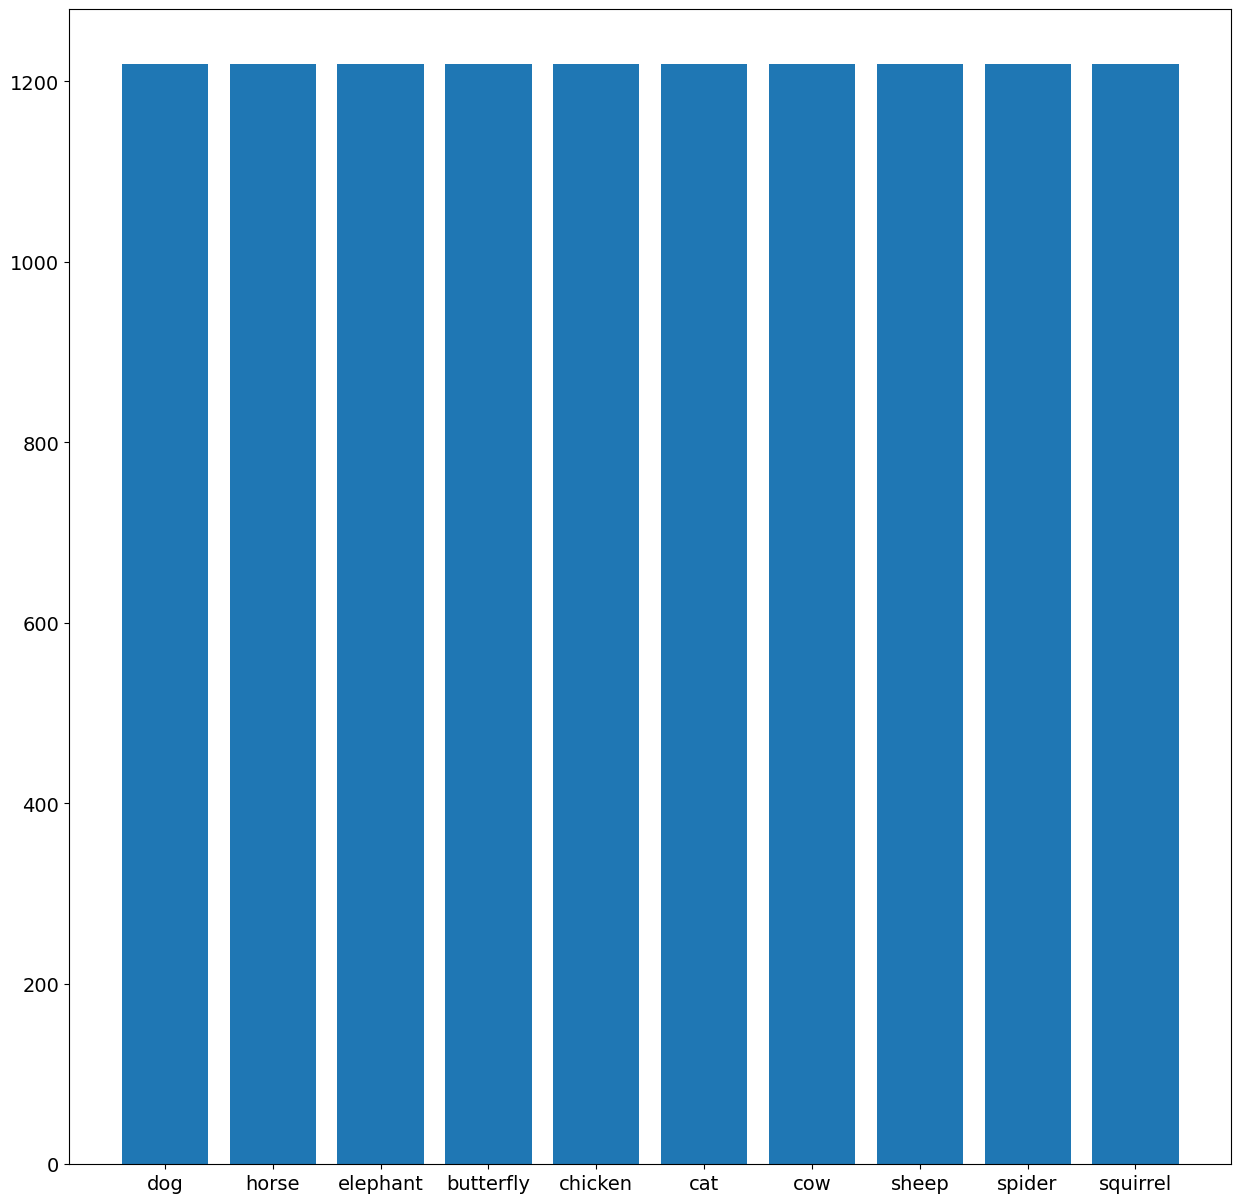

<Figure size 640x480 with 0 Axes>

In [4]:
binarr = []
for i in range(0,10):
    binarr.append(np.count_nonzero(oversampled_y_train==i))

labels = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']
plt.figure(figsize=(15, 15)) 
plt.bar(labels, binarr)
plt.show()

plt.savefig("/kaggle/working/balanced_plot.pdf", format="pdf", bbox_inches="tight")



In [13]:
auggen=ImageDataGenerator(zoom_range= 0.2,
                           horizontal_flip = True,
                           rotation_range = 45,
                           fill_mode='nearest',
                           width_shift_range=0.2, 
                           height_shift_range=0.2,
                           shear_range=0.6,
                           channel_shift_range=0.5
                          )

traindata=auggen.flow(oversampled_x_train, oversampled_y_train)


# labels = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']
# samples=traindata.__next__()
# images=samples[0]
# target=samples[1]
# plt.rcParams['figure.figsize']=(20,20)

# for i in range(15):
#     plt.subplot(5,5,i+1)
#     plt.subplots_adjust(hspace=0.3,wspace=.3)
#     plt.imshow(images[i])
#     plt.title(f"Class: {labels[target[i]]}")
#     plt.axis('off')
    
# plt.savefig("/kaggle/working/img_plot.pdf", format="pdf", bbox_inches="tight")

In [ ]:
labels = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']
samples=traindata.__next__()
images=samples[0]
target=samples[1]
plt.rcParams['figure.figsize']=(20,20)

for i in range(15):
    plt.subplot(5,5,i+1)
    plt.subplots_adjust(hspace=0.3,wspace=.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[np.argmax(target[i],axis=0)]}")
    plt.axis('off')
    
plt.savefig("/kaggle/working/img_plot.pdf", format="pdf", bbox_inches="tight")

In [20]:
from neptune.integrations.tensorflow_keras import NeptuneCallback
import keras

neptune_cbk = NeptuneCallback(run=run, base_namespace="metrics")

params = {"batch_size": batch_size, "decay_steps": 10, "initial_learning_rate": 0.007, "momentum": 0.5}
run["parameters"] = params

lr_schedule = keras.optimizers.schedules.CosineDecay(
    params["initial_learning_rate"], #0.01
    params["decay_steps"],
    alpha=0.0,
    name=None,
    warmup_target=0.01,
    warmup_steps=5
)

optimizer = tf.keras.optimizers.experimental.SGD(
    learning_rate=params["initial_learning_rate"],
    momentum = params["momentum"]
)


In [21]:
# TRANSER LEARNING

model=tf.keras.applications.vgg16.VGG16(include_top=False,
                                             weights='imagenet',
                                             input_shape=(img_size,img_size,3))

model.trainable = False
# base_model.summary()
# # freezujemy 4 ostatnie warstwy modelu
# for layer in model.layers[:-4]:
#     layer.trainable=False

# model.summary()

last_output = model.output
x = GlobalAveragePooling2D()(last_output)
x = Dense(128,activation="relu")(x)
x = Dense(512,activation="relu")(x)
outputs = Dense(10,activation="softmax")(x) # zmieniamy na 10 kategorii bo 10 zwierzatek
model = Model(inputs=model.inputs,outputs=outputs)

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# FROM SCRATCH

model=tf.keras.applications.vgg16.VGG16(weights=None,
                                        input_shape=(img_size,img_size,3),
                                        classes=10)

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

Epoch 1/100
395/395 [==============================] - ETA: 0s - loss: 2.2558 - accuracy: 0.1714
Epoch 1: val_loss improved from inf to 3.70705, saving model to VGG_balnced.h5
395/395 [==============================] - 149s 376ms/step - loss: 2.2558 - accuracy: 0.1714 - val_loss: 3.7071 - val_accuracy: 0.3552
Epoch 2/100
395/395 [==============================] - ETA: 0s - loss: 2.1067 - accuracy: 0.2741
Epoch 2: val_loss improved from 3.70705 to 3.57488, saving model to VGG_balnced.h5
395/395 [==============================] - 146s 369ms/step - loss: 2.1067 - accuracy: 0.2741 - val_loss: 3.5749 - val_accuracy: 0.3641
Epoch 3/100
395/395 [==============================] - ETA: 0s - loss: 1.9192 - accuracy: 0.3282
Epoch 3: val_loss improved from 3.57488 to 3.47526, saving model to VGG_balnced.h5
395/395 [==============================] - 147s 371ms/step - loss: 1.9192 - accuracy: 0.3282 - val_loss: 3.4753 - val_accuracy: 0.4737
Epoch 4/100
395/395 [==============================] - ETA:

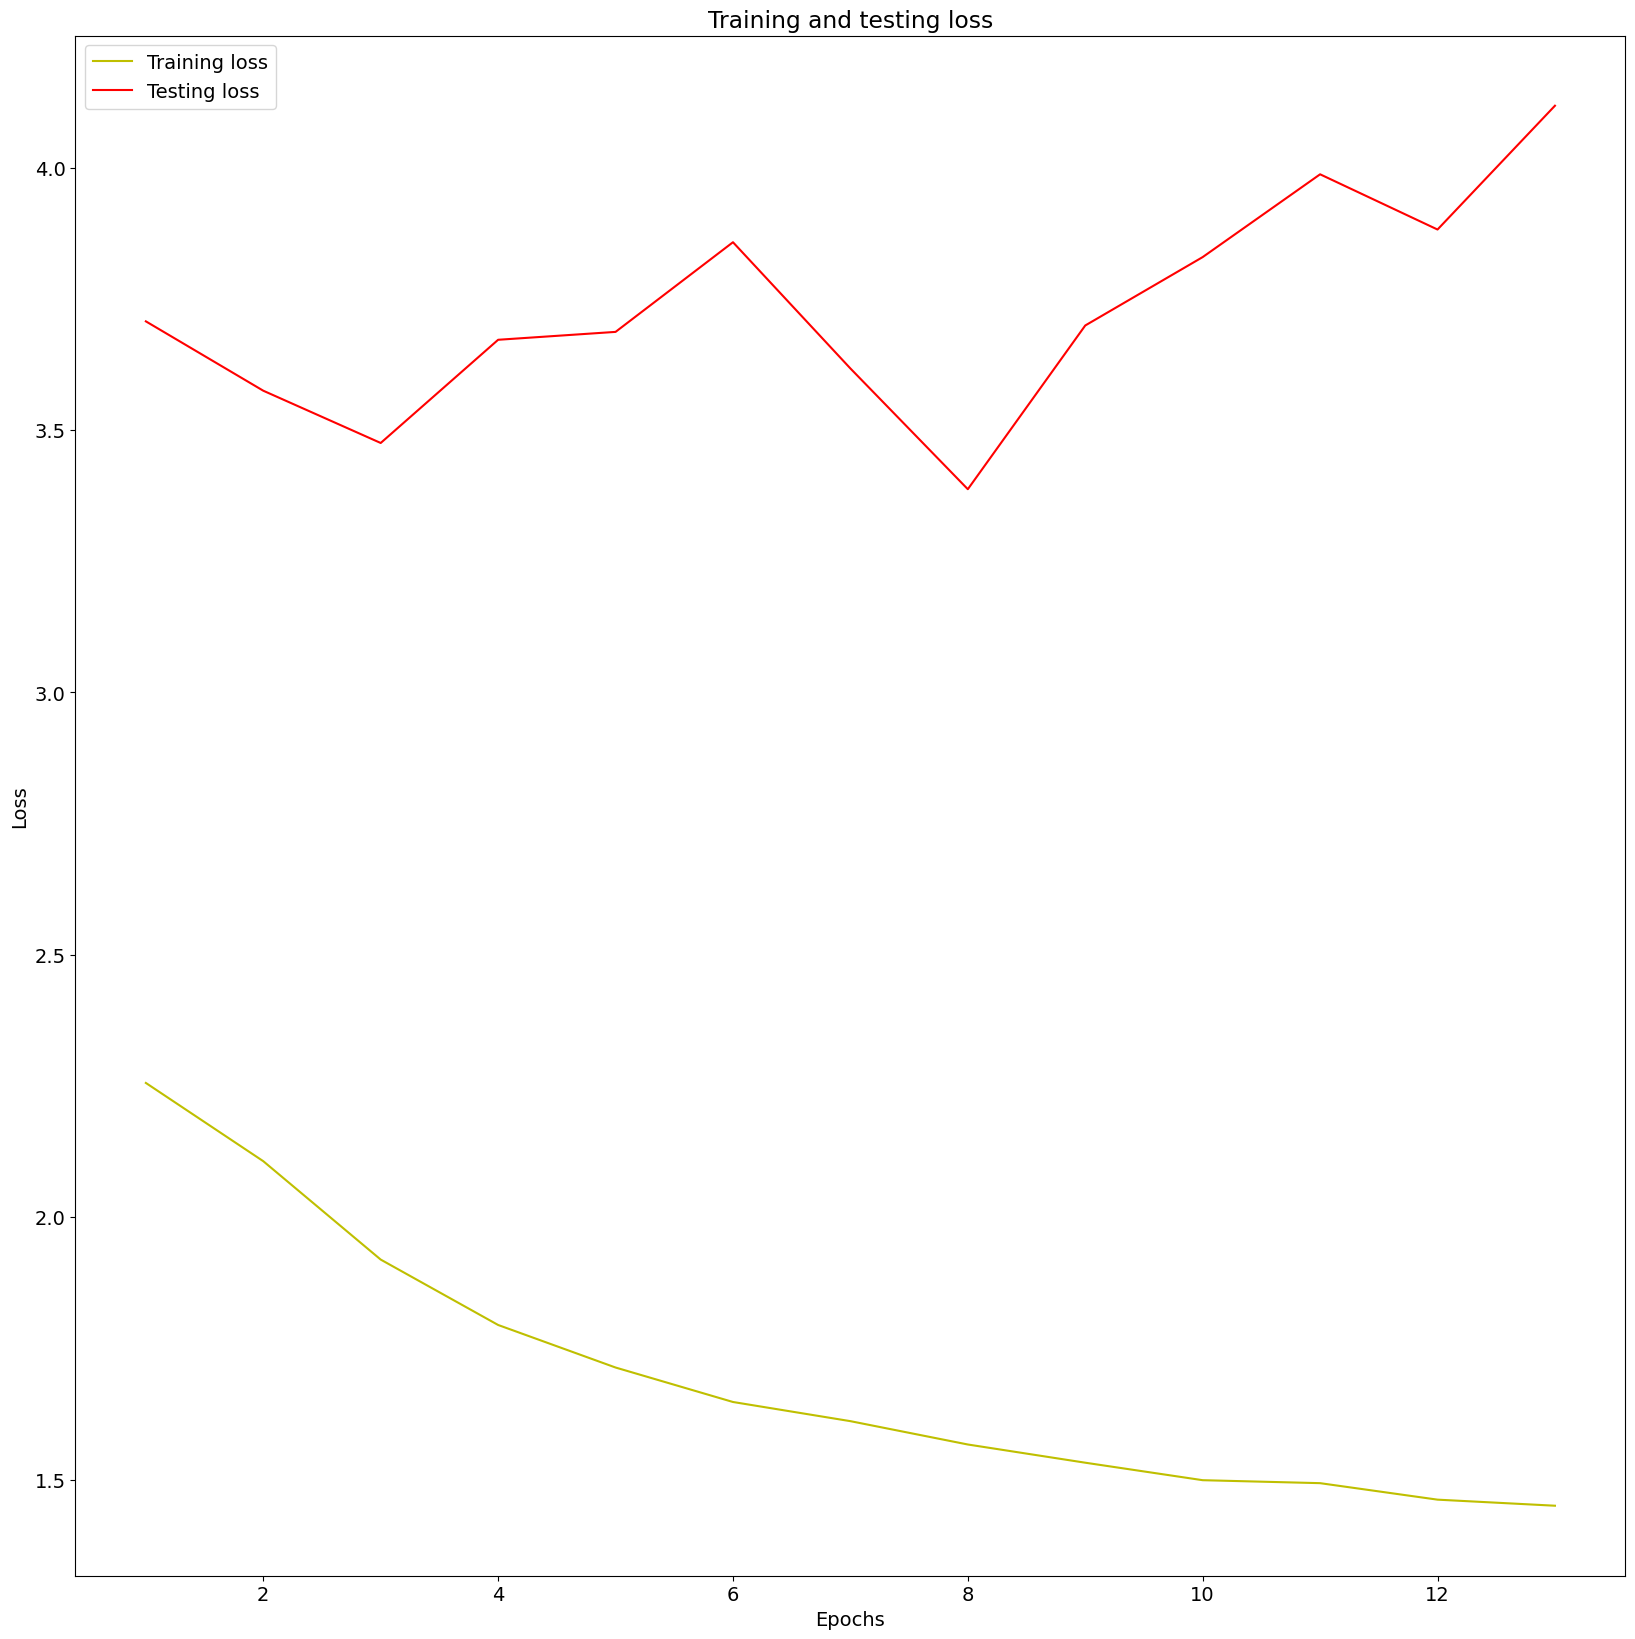

<Figure size 2000x2000 with 0 Axes>

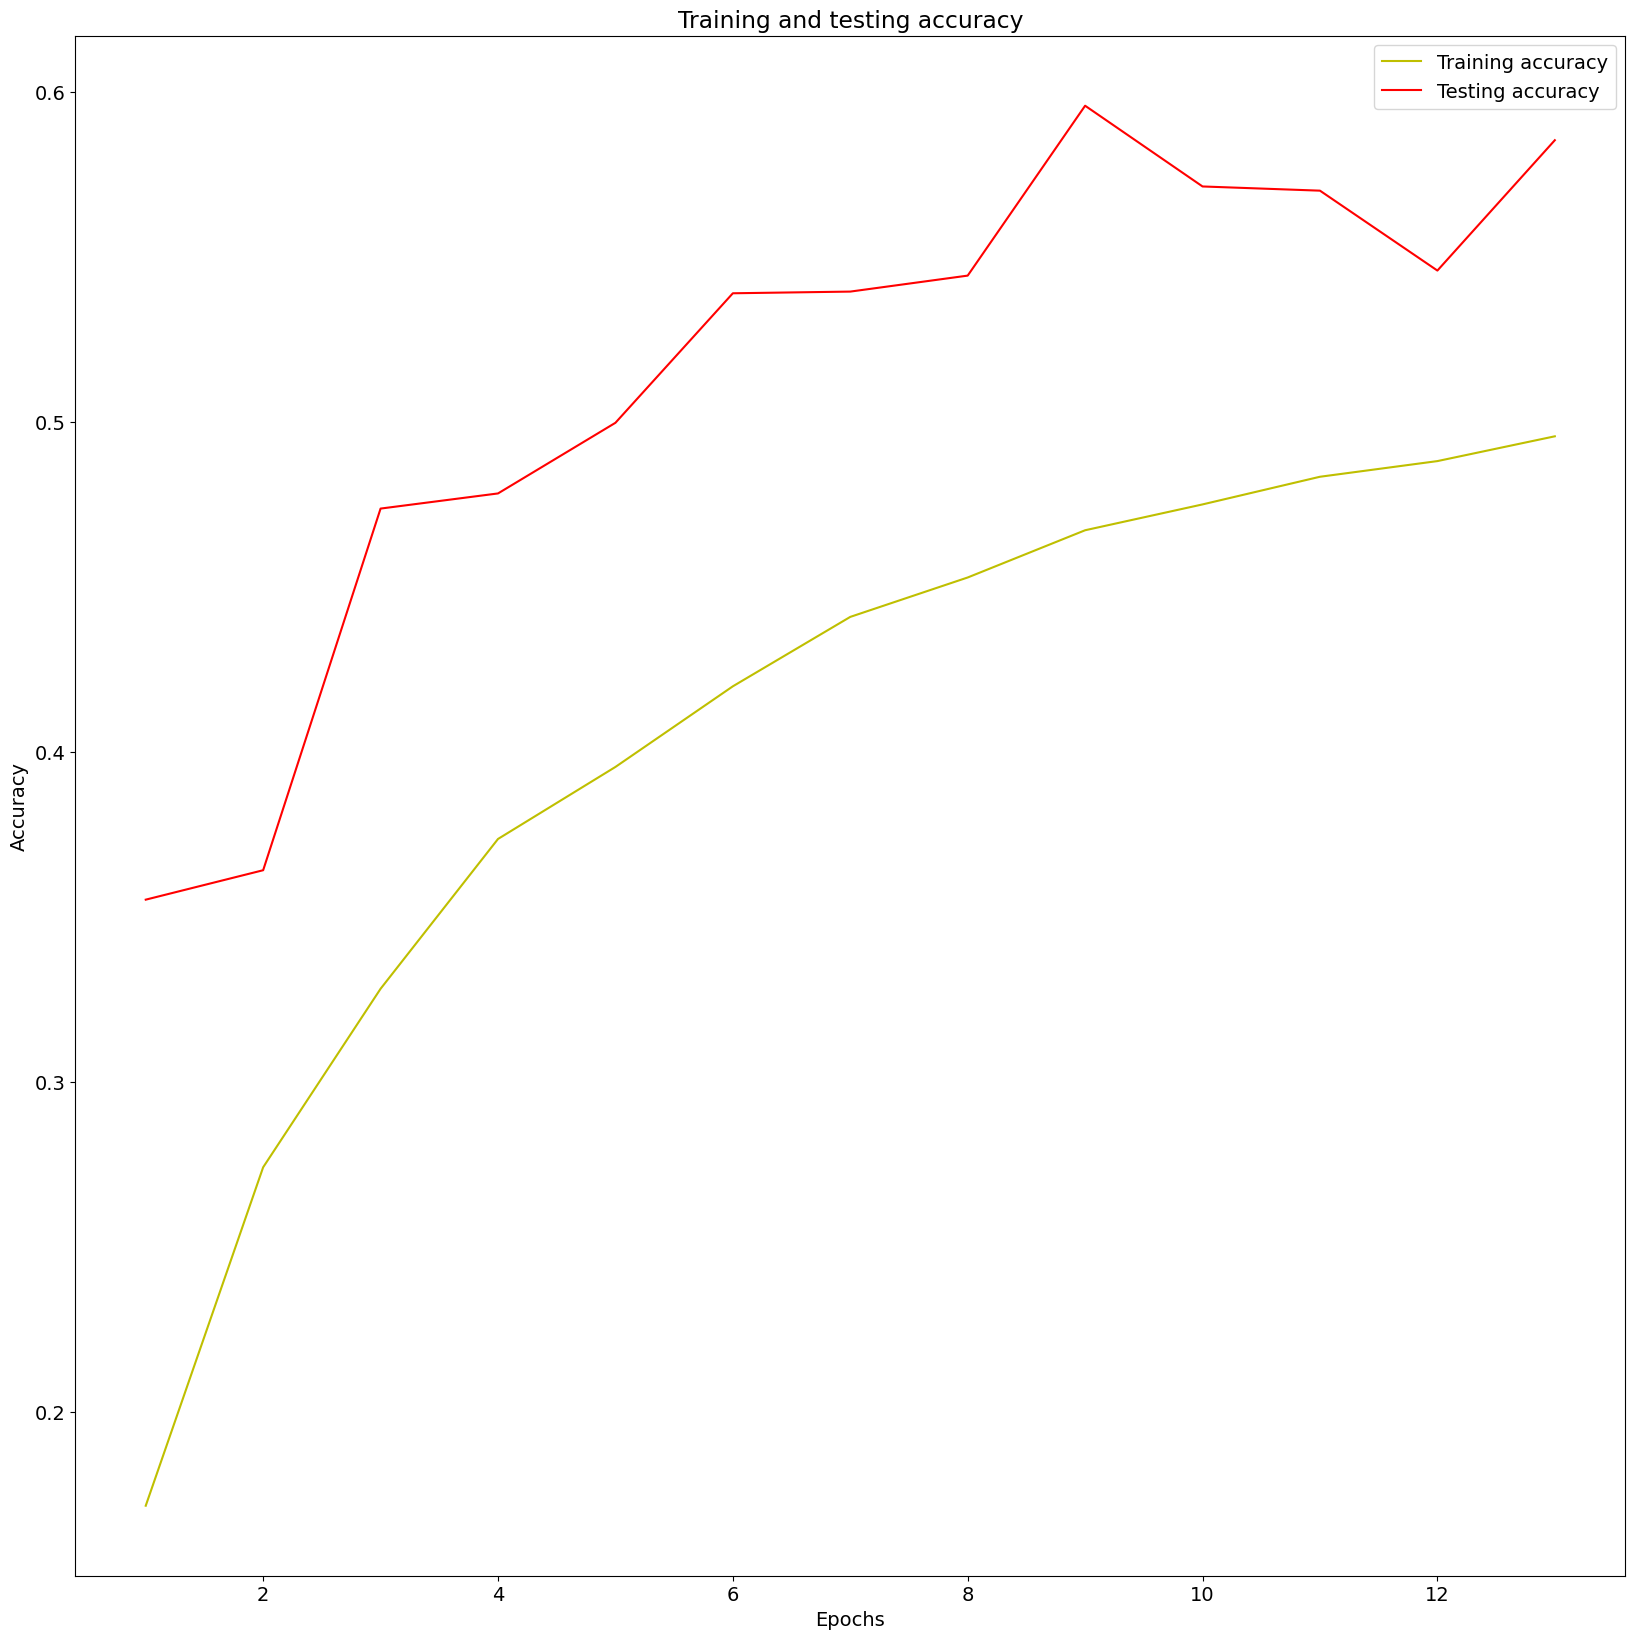

<Figure size 2000x2000 with 0 Axes>

In [22]:
# model = tf.keras.models.load_model("/kaggle/working/VGG_scratch_next.h5")
# optimizer = tf.keras.optimizers.experimental.SGD(
#     learning_rate=0.007,
#     momentum = params["momentum"]
# )
# model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

model_path = "VGG_balnced.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

history = model.fit(traindata,epochs=100,validation_data=valdata,callbacks=[checkpoint,earlystopping, neptune_cbk])

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Testing loss')
plt.title('Training and testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.savefig("/kaggle/working/loss_plot.pdf", format="pdf", bbox_inches="tight")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(2)
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Testing accuracy')
plt.title('Training and testing accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig("/kaggle/working/acc_plot.pdf", format="pdf", bbox_inches="tight")


In [23]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.
All 1 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/m.golebiowska556/NNanimals/e/NNAN-15/metadata


# 4.1 Wyniki dla VGG

In [ ]:
model = tf.keras.models.load_model("/kaggle/working/VGG_scratch_next.h5")

plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

labels = ['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'spider', 'squirrel']

y_test = valdata.classes
y_pred = model.predict(valdata)
y_pred = np.argmax(y_pred,axis=1)

print(classification_report(y_test,y_pred,target_names = labels))

62/62 [==============================] - 11s 172ms/step
              precision    recall  f1-score   support

         dog       0.63      0.57      0.60       729
       horse       0.43      0.57      0.49       393
    elephant       0.55      0.43      0.48       216
   butterfly       0.62      0.88      0.73       316
     chicken       0.93      0.23      0.37       464
         cat       0.76      0.61      0.67       250
         cow       0.26      0.77      0.39       279
       sheep       0.33      0.22      0.26       273
      spider       0.88      0.70      0.78       723
    squirrel       0.39      0.30      0.34       279

    accuracy                           0.54      3922
   macro avg       0.58      0.53      0.51      3922
weighted avg       0.63      0.54      0.55      3922



In [25]:
scores = model.evaluate(valdata)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

62/62 [==============================] - 11s 172ms/step - loss: 3.3872 - accuracy: 0.5444
evaluate accuracy: 54.44%


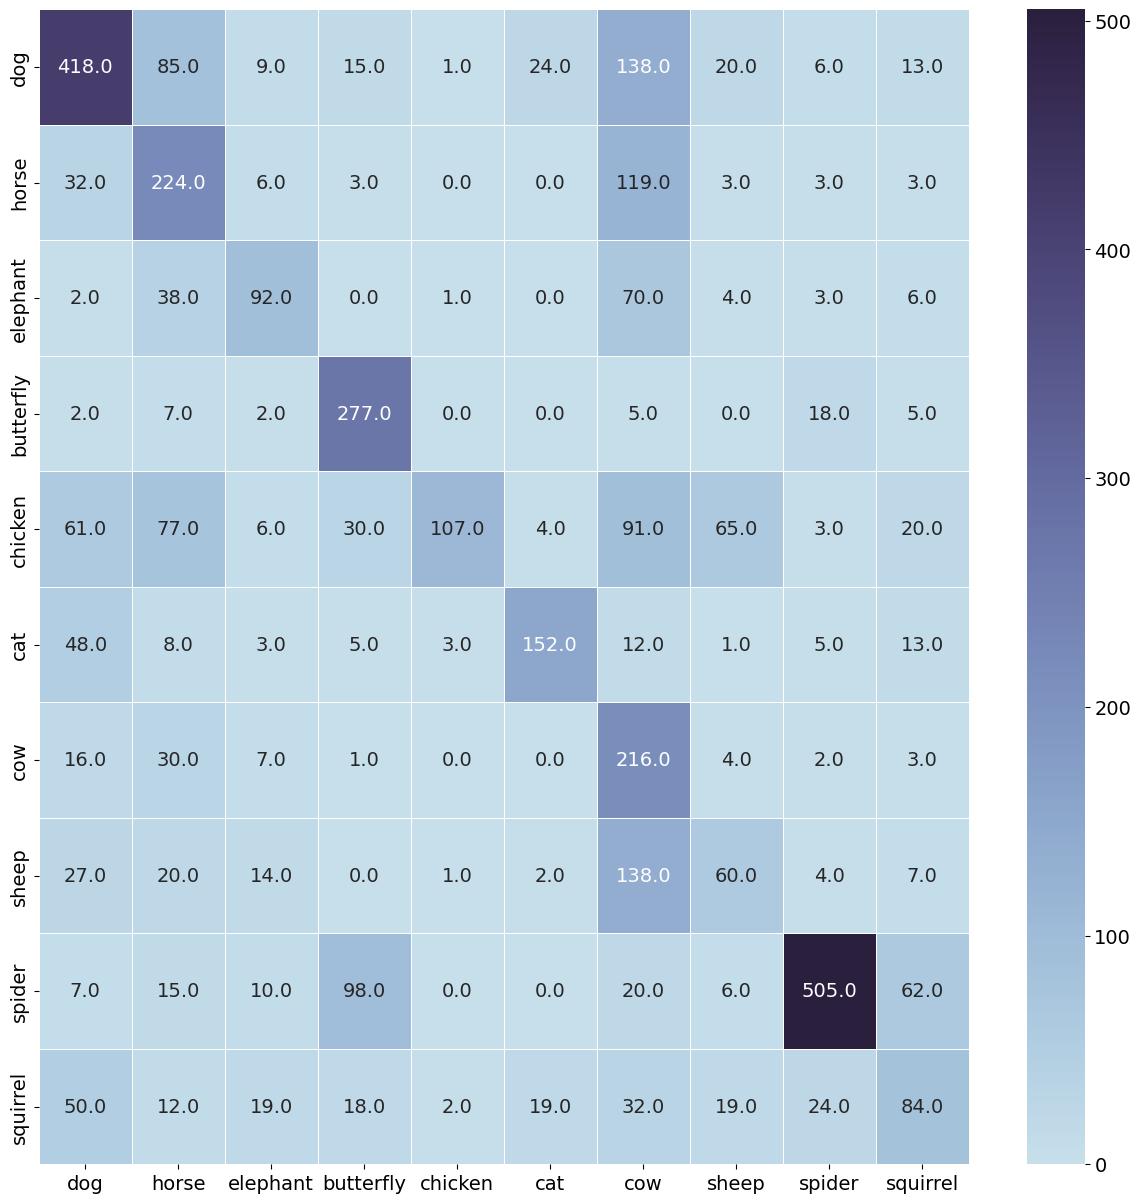

In [27]:
# confusion matrix
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(15, 15)) 
sns.heatmap(cm, annot=True, fmt=".1f", linewidth=.5,
           cmap=sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True),
           xticklabels=labels,  yticklabels=labels)
plt.savefig("/kaggle/working/matrix.pdf", format="pdf", bbox_inches="tight")